### Load and Subset the MRDS Dataset
Load the USGS MRDS dataset and filter records to include only sites in Amador County, California. This provides a focused dataset for analysis.
Datasets can be downloaded from here: https://mrdata.usgs.gov/mrds/
Code can be found here:
https://github.com/smorganstern/Quest-for-Golden-Treasures/releases

In [1]:
import pandas as pd
# Load MRDS dataset
df = pd.read_csv("mrds.csv", low_memory=False)
print('Total Rows in MRDS Dataset = ', df.shape[0])
# Filter for Amador County in California
df_amador = df[
    (df['state'] == 'California') &
    (df['county'].str.contains('Amador', case=False, na=False))
].copy()


Total Rows in MRDS Dataset =  304632


### Define Binary Target `has_gold`
Creates a boolean label where `True` indicates the site contains gold, based on any mention of 'gold' in `commod1`, `commod2`, or `commod3`.


In [2]:
# Create binary target based on gold mentions
df_amador['has_gold'] = df_amador[['commod1', 'commod2', 'commod3']].apply(
    lambda row: any('gold' in str(x).lower() for x in row), axis=1
)
df_amador_gold = df_amador[df_amador['has_gold']].copy()



### Gold Deposit Map – Amador County
Plots all gold-bearing sites in Amador County, providing a spatial view of known deposits.


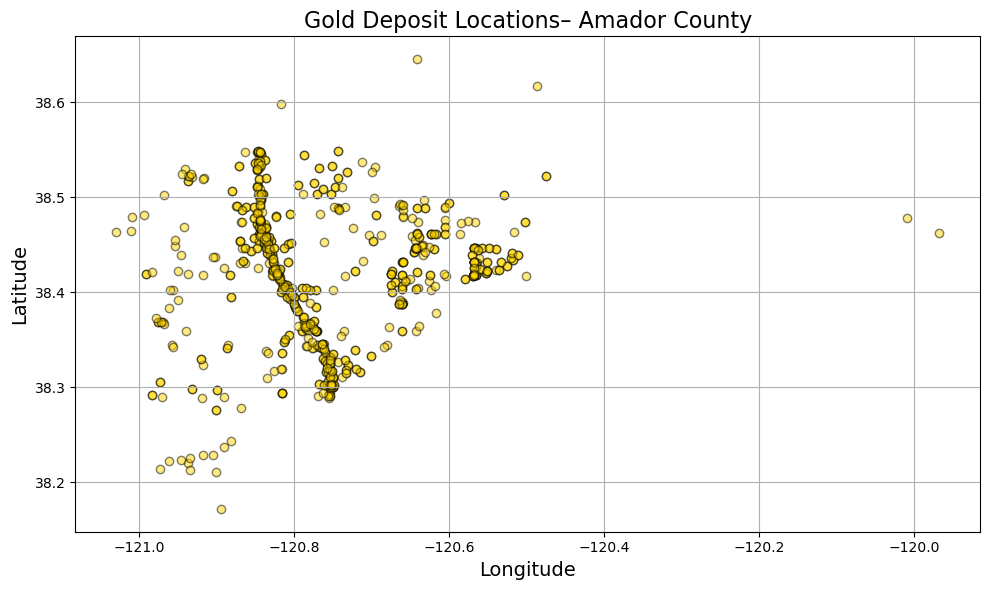

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(
    df_amador_gold['longitude'],
    df_amador_gold['latitude'],
    alpha=0.5,
    color='gold',
    edgecolors='black'
)
plt.title("Gold Deposit Locations– Amador County", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


## Engineer Quartz Proximity Feature
Create Quartz Indicator
Adds a binary feature `has_quartz` if quartz is present in the `ore` or `gangue` fields, based on the geological association between quartz veins and gold deposits.


In [4]:
# Flag quartz presence in ore or gangue
df_amador['has_quartz'] = df_amador[['ore', 'gangue']].apply(
    lambda row: any('quartz' in str(x).lower() for x in row), axis=1
)
df_amador_quartz = df_amador[df_amador['has_quartz']].copy()

Map Quartz Locations
### Quartz Deposit Map – Amador County
Shows the spatial distribution of quartz occurrences to explore potential geological correlations.


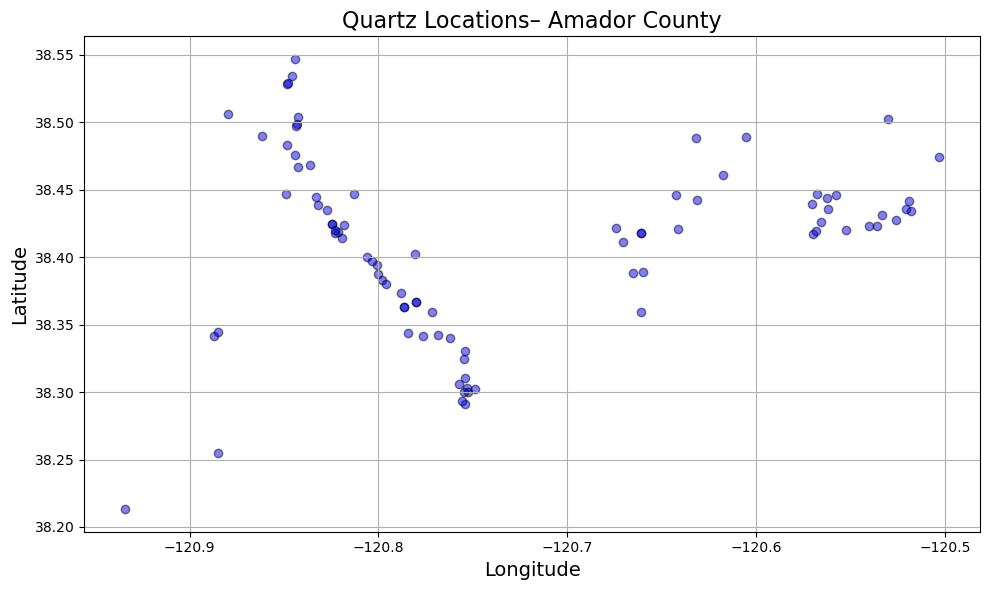

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(
    df_amador_quartz['longitude'],
    df_amador_quartz['latitude'],
    alpha=0.5,
    color='blue',
    edgecolors='black'
)
plt.title("Quartz Locations– Amador County", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


### Combined Gold and Quartz Map
Overlays gold and quartz locations to illustrate spatial proximity and potential exploration targets.


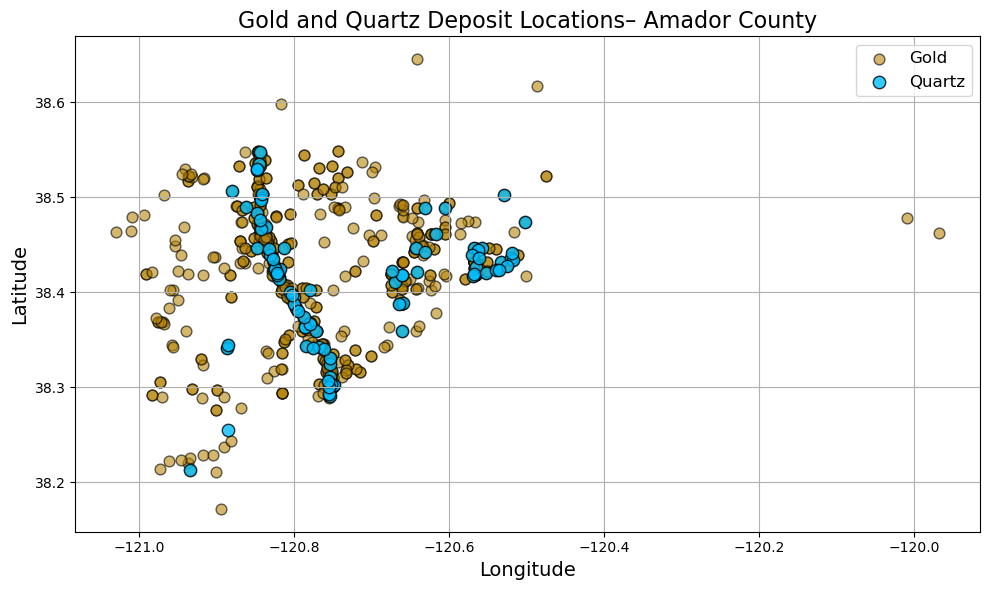

In [6]:
plt.figure(figsize=(10, 6))
# Gold deposits
plt.scatter(
    df_amador_gold['longitude'],
    df_amador_gold['latitude'],
    alpha=0.6,
    color='darkgoldenrod',
    edgecolors='black',
    s=60,
    label='Gold'
)
# Quartz deposits
plt.scatter(
    df_amador_quartz['longitude'],
    df_amador_quartz['latitude'],
    alpha=0.8,
    color='deepskyblue',
    edgecolors='black',
    s=80,
    label='Quartz'
)
plt.title("Gold and Quartz Deposit Locations– Amador County", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.grid(True)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()


### Select Relevant Modeling Columns
Retains location, geological, and engineered features, along with the target variable `has_gold`. Commodity columns are excluded to avoid target leakage.


In [7]:
import numpy as np
cols_to_keep = [
    'latitude', 'longitude', 'state', 'county',
    'ore', 'gangue', 'other_matl',
    'has_quartz', 'has_gold'
]
df_model = df_amador[cols_to_keep].copy()


### Mask 'Gold' in Ore Column
Replaces exact matches of 'gold' in the `ore` column with NaN to prevent direct target leakage.
This is because all the rows that contain Gold as the ore column also contain Gold in the commod(1-3).

In [8]:
df_model['ore'] = df_model['ore'].str.strip().str.lower()
df_model.loc[df_model['ore'] == 'gold', 'ore'] = np.nan


### Preprocessing – SimpleImputer Setup
Imports the imputer to handle missing categorical and numeric values.




In [9]:
from sklearn.impute import SimpleImputer
SimpleImputer(fill_value='missing', strategy='constant')

SimpleImputer(fill_value='missing', strategy='constant')

### Preprocessing – OneHotEncoder Setup
Imports the encoder for categorical variables to prepare for model training.


In [10]:
from sklearn.preprocessing import OneHotEncoder

OneHotEncoder(handle_unknown='ignore')

OneHotEncoder(handle_unknown='ignore')

### Preprocessing Configuration
Sets up transformers for numeric, categorical, and binary features in preparation for modeling.


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df_model.drop(columns='has_gold')
y = df_model['has_gold']

numeric_features = ['latitude', 'longitude']
categorical_features = ['state', 'county', 'ore', 'gangue', 'other_matl']
binary_features = ['has_quartz']

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features),
    ('bin', 'passthrough', binary_features)
])


Model Training
Combines preprocessing steps with a Random Forest classifier, then fits the model on the training data.


In [12]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
clf.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['state', 'county', 'ore',
                                                   'gangue', 'other_matl']),
                                                 ('bin', 'passthrough',
                                                  ['has_quartz'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

### Feature Importance Extraction
Retrieves feature names from all preprocessing branches, aligns them with importance scores, and removes dummy `_missing` categories.


In [13]:
cat_encoder = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
num_features = clf.named_steps['preprocessor'].named_transformers_['num'].named_steps['scaler'].get_feature_names_out()
cat_features = cat_encoder.get_feature_names_out()
bin_features = ['has_quartz']

all_features = np.concatenate([num_features, cat_features, bin_features])

important_features = pd.Series(clf.named_steps['classifier'].feature_importances_, index=all_features)
important_features = important_features[~important_features.index.str.contains('_missing')]
important_features.sort_values(ascending=False).head(15)


x1                                             0.609180
x0                                             0.310060
x2_chromite                                    0.016520
x2_psilomelane, pyrolusite, rhodonite          0.009203
has_quartz                                     0.007199
x2_sand                                        0.004485
x3_Quartz                                      0.003718
x2_psilomelane, pyrolusite                     0.002946
x2_psilomelane, rhodonite                      0.002531
x2_mineral pigments                            0.002117
x2_chromite, gold                              0.001693
x2_chalcopyrite, galena, pyrite, sphalerite    0.001659
x2_soapstone                                   0.001622
x1_Amador                                      0.001583
x4_Chromite, Serpentine                        0.001151
dtype: float64

### Top Feature Importances – Random Forest
Displays the top predictors as a horizontal bar chart for interpretability.


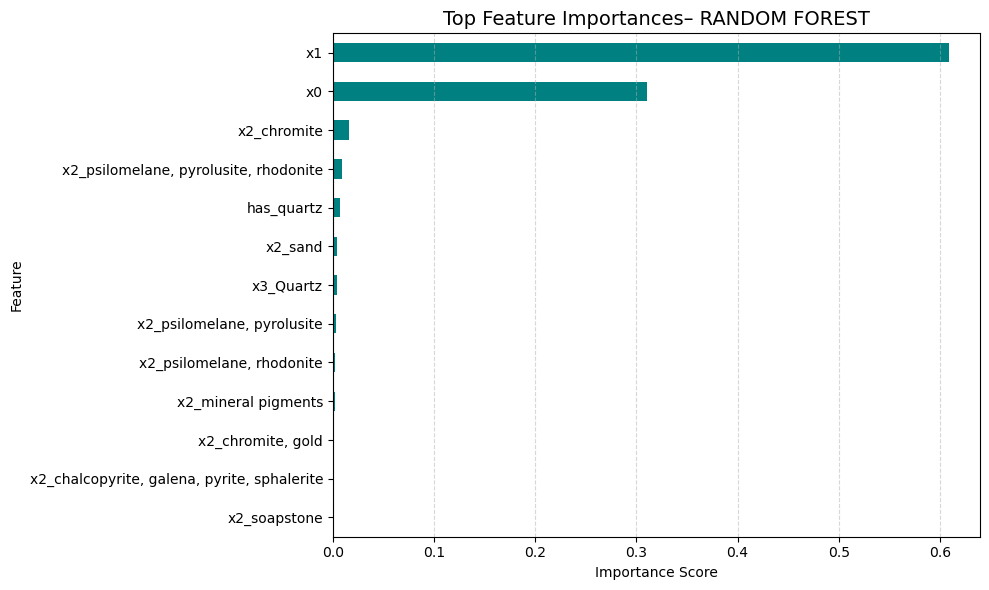

In [14]:
top_n = 13
top_features = important_features.sort_values(ascending=True).tail(top_n)

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='teal')
plt.title('Top Feature Importances– RANDOM FOREST', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


### Model Evaluation
Generates a confusion matrix, classification report, and ROC–AUC score on the test set to assess predictive performance.

## Decision Tree

I apply a **Decision Tree Classifier** using the Gini impurity criterion to split nodes.  
This model is simple, interpretable, and can reveal the structure of decision boundaries in the dataset.  
I evaluate its performance with precision, recall, F1‑score, and ROC–AUC, and then plot a confusion matrix to examine class‑level predictions.


Decision Tree Results:
              precision    recall  f1-score   support

       False       0.77      0.74      0.75        76
        True       0.91      0.92      0.91       211

    accuracy                           0.87       287
   macro avg       0.84      0.83      0.83       287
weighted avg       0.87      0.87      0.87       287

ROC–AUC: 0.8341855824395112


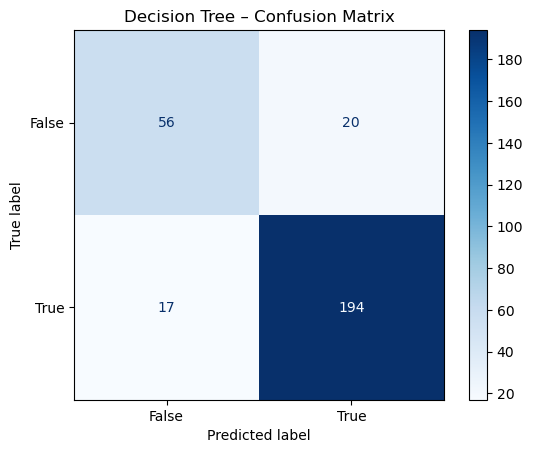

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

dt_pipe = Pipeline([
    ('preprocessor', preprocessor),                 # use your existing ColumnTransformer
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_pipe.fit(X_train, y_train)
y_pred_dt = dt_pipe.predict(X_test)
y_proba_dt = dt_pipe.predict_proba(X_test)[:, 1]

print("Decision Tree Results:")
print(classification_report(y_test, y_pred_dt))
print("ROC–AUC:", roc_auc_score(y_test, y_proba_dt))

cm_dt = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=dt_pipe.named_steps['classifier'].classes_)\
    .plot(cmap='Blues', values_format='d')
plt.title("Decision Tree – Confusion Matrix")
plt.show()


### Naïve Bayes with densifier

Naive Bayes Results:
              precision    recall  f1-score   support

       False       0.29      1.00      0.45        76
        True       1.00      0.13      0.23       211

    accuracy                           0.36       287
   macro avg       0.65      0.57      0.34       287
weighted avg       0.81      0.36      0.29       287

ROC–AUC: 0.7608194063357445


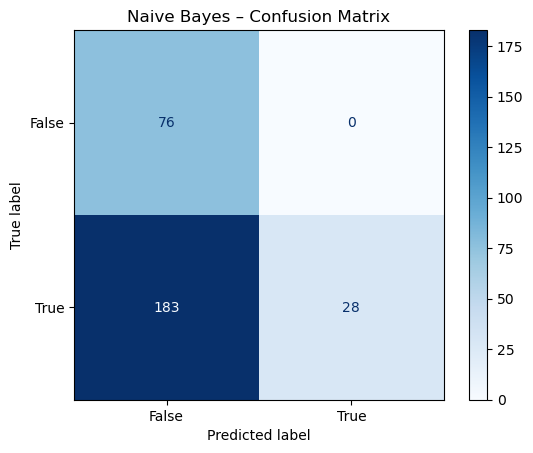

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import FunctionTransformer

nb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', FunctionTransformer(lambda X: X.toarray(), accept_sparse=True)),
    ('classifier', GaussianNB())
])

nb_pipe.fit(X_train, y_train)
y_pred_nb = nb_pipe.predict(X_test)
y_proba_nb = nb_pipe.predict_proba(X_test)[:, 1]

print("Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb))
print("ROC–AUC:", roc_auc_score(y_test, y_proba_nb))

cm_nb = confusion_matrix(y_test, y_pred_nb)
ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=nb_pipe.named_steps['classifier'].classes_)\
    .plot(cmap='Blues', values_format='d')
plt.title("Naive Bayes – Confusion Matrix")
plt.show()


### SVC with densifier

SVM Results:
              precision    recall  f1-score   support

       False       0.70      0.59      0.64        76
        True       0.86      0.91      0.88       211

    accuracy                           0.83       287
   macro avg       0.78      0.75      0.76       287
weighted avg       0.82      0.83      0.82       287

ROC–AUC: 0.7234035919181842


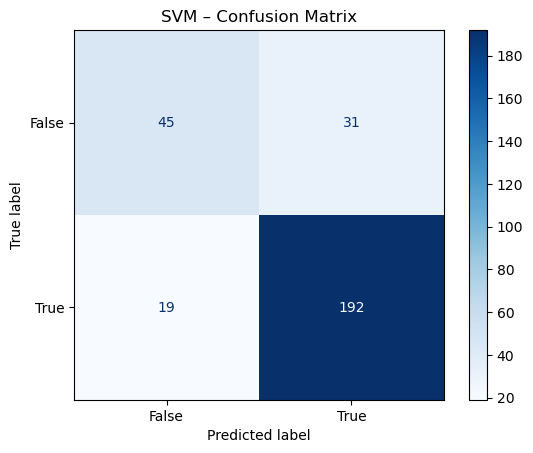

In [17]:
from sklearn.svm import SVC

svm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', FunctionTransformer(lambda X: X.toarray(), accept_sparse=True)),
    ('classifier', SVC(kernel='linear', probability=True, random_state=42))
])

svm_pipe.fit(X_train, y_train)
y_pred_svm = svm_pipe.predict(X_test)
y_proba_svm = svm_pipe.predict_proba(X_test)[:, 1]

print("SVM Results:")
print(classification_report(y_test, y_pred_svm))
print("ROC–AUC:", roc_auc_score(y_test, y_proba_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm_pipe.named_steps['classifier'].classes_)\
    .plot(cmap='Blues', values_format='d')
plt.title("SVM – Confusion Matrix")
plt.show()


### Confusion Matrix - Random Forest

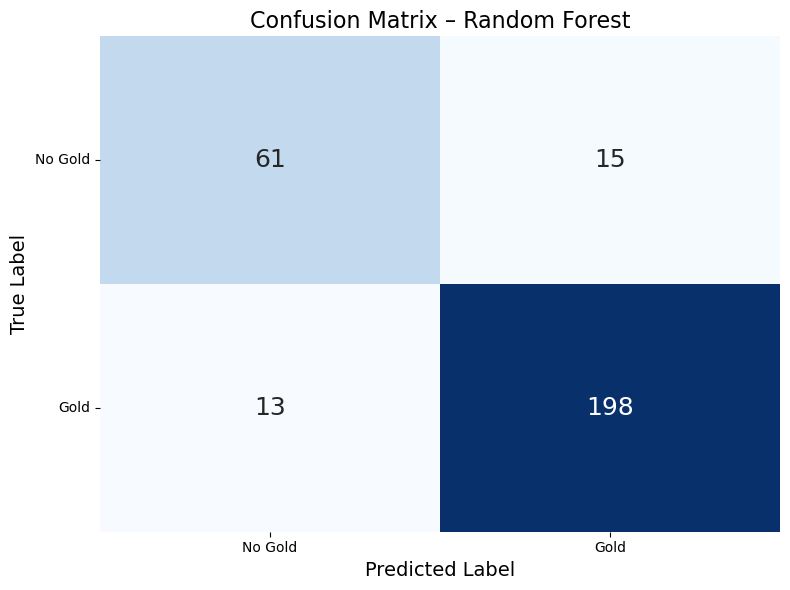

              precision    recall  f1-score   support

     No Gold       0.82      0.80      0.81        76
        Gold       0.93      0.94      0.93       211

    accuracy                           0.90       287
   macro avg       0.88      0.87      0.87       287
weighted avg       0.90      0.90      0.90       287

ROC–AUC Score: 0.9387627837365927


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

# Predictions
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class labels for display
labels = ['No Gold', 'Gold']

# Plot as a large heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar=False, annot_kws={"size": 18})
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix – Random Forest', fontsize=16)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Print detailed metrics
print(classification_report(y_test, y_pred, target_names=labels))
print("ROC–AUC Score:", roc_auc_score(y_test, y_proba))

### Random Forest Hyperparameter Optimization
Compares GridSearchCV and RandomizedSearchCV to identify improved hyperparameters for the Random Forest classifier.  
Uses stratified folds, recall scoring, and measures fit times for each approach.


In [19]:
import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Common pipeline
base_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# GridSearchCV
grid_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10],
    'model__min_samples_split': [2, 3]
}
grid_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=base_pipe,
    param_grid=grid_params,
    cv=grid_cv,
    scoring='recall',
    n_jobs=-1,
    verbose=2
)
start_grid = time.time()
grid_search.fit(X_train, y_train)
end_grid = time.time()
grid_best = grid_search.best_estimator_
grid_pred = grid_best.predict(X_test)
grid_auc = roc_auc_score(y_test, grid_best.predict_proba(X_test)[:, 1])

# RandomizedSearchCV
random_params = {
    'model__n_estimators': [50, 100, 150, 200],
    'model__max_depth': [None, 5, 10, 15],
    'model__min_samples_split': [2, 3, 4, 5]
}
random_search = RandomizedSearchCV(
    estimator=base_pipe,
    param_distributions=random_params,
    n_iter=10,
    cv=grid_cv,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=2
)
start_rand = time.time()
random_search.fit(X_train, y_train)
end_rand = time.time()
rand_best = random_search.best_estimator_
rand_pred = rand_best.predict(X_test)
rand_auc = roc_auc_score(y_test, rand_best.predict_proba(X_test)[:, 1])

# Results
print("\nGridSearchCV Results:")
print("Best Params:", grid_search.best_params_)
print(classification_report(y_test, grid_pred))
print("ROC–AUC:", grid_auc)
print(f"Time taken: {(end_grid - start_grid):.2f} seconds")

print("\nRandomizedSearchCV Results:")
print("Best Params:", random_search.best_params_)
print(classification_report(y_test, rand_pred))
print("ROC–AUC:", rand_auc)
print(f"Time taken: {(end_rand - start_rand):.2f} seconds")


Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits

GridSearchCV Results:
Best Params: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}
              precision    recall  f1-score   support

       False       0.83      0.78      0.80        76
        True       0.92      0.94      0.93       211

    accuracy                           0.90       287
   macro avg       0.88      0.86      0.87       287
weighted avg       0.90      0.90      0.90       287

ROC–AUC: 0.9358006984285357
Time taken: 7.30 seconds

RandomizedSearchCV Results:
Best Params: {'model__n_estimators': 100, 'model__min_samples_split': 3, 'model__max_depth': None}
              precision    recall  f1-score   support

       False       0.82      0.80      0.81        76
        True       0.93      0.94      0.93       211

    accuracy                           0.90       287
   macro avg       0.88      0.

### Attach Predictions to Coordinates
Adds model predictions to the corresponding latitude and longitude coordinates from the test set in preparation for spatial plotting.


In [20]:
# Get predictions
y_pred = clf.predict(X_test)

# Reattach coordinates for mapping
coords = X_test[['latitude', 'longitude']].copy()
coords['prediction'] = y_pred


### Predicted Gold Locations Map – Amador County
Plots predicted gold sites in gold and non‑gold sites in gray, providing a spatial interpretation of model outputs.


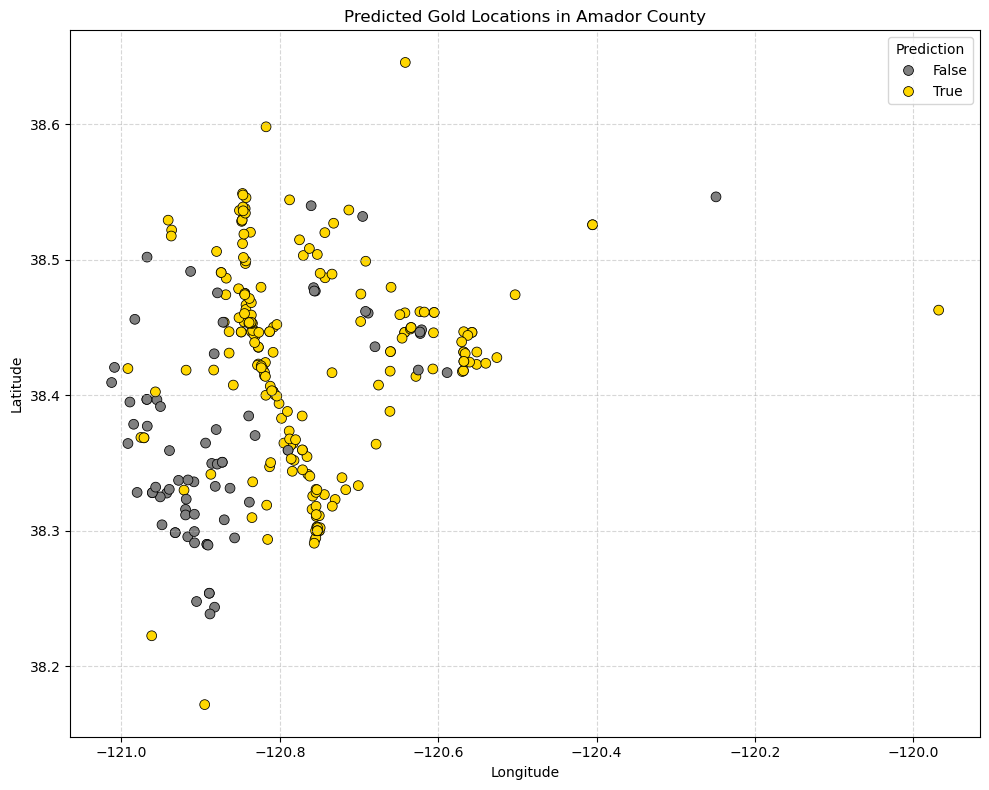

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=coords,
    x='longitude',
    y='latitude',
    hue='prediction',
    palette={True: 'gold', False: 'gray'},
    s=50,
    edgecolor='black'
)
plt.title('Predicted Gold Locations in Amador County')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Prediction')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Summary
## Most accurate / best overall: Random Forest - consistently delivered the best combination of accuracy 90%, high precision ≥0.92, high recall 0.94, and highest ROC‑AUC 0.939.

### High recall means the model finds most of the sites that truly contain gold, missing very few. 
### High precision means that most of the sites flagged as gold‑positive actually contain gold.